In [2]:
# import libraries 
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import os
import astropy.io.fits as pyfits
from astropy.table import Table
from matplotlib.gridspec import GridSpec
import random 
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence

# import modules that I made 
import plot_settings
import dp_tools
import lstm_model 
import training
import testing

### Lets load the data 

In [3]:
### change these variables 
target_name = 'Kepler-63'
mission_name ='Kepler'
cadence_name = 'long'
quarter_ls= [3,4,5,6,7,8]

In [4]:
x_quarter_ls, y_quarter_ls, w_quarter_ls, n_quarter = dp_tools.get_data(target_name, mission_name, cadence_name, quarter_ls)

### Pre-process the data 

In [5]:
# lets cut the data to the smallest length from the quarter list 
x_ls = dp_tools.minimum_cut(x_quarter_ls)
y_ls = dp_tools.minimum_cut(y_quarter_ls)
w_ls = dp_tools.minimum_cut(w_quarter_ls)

In [6]:
# lets remove the linear trend 
y_ls = dp_tools.remove_linear_trend(x_ls, y_ls)

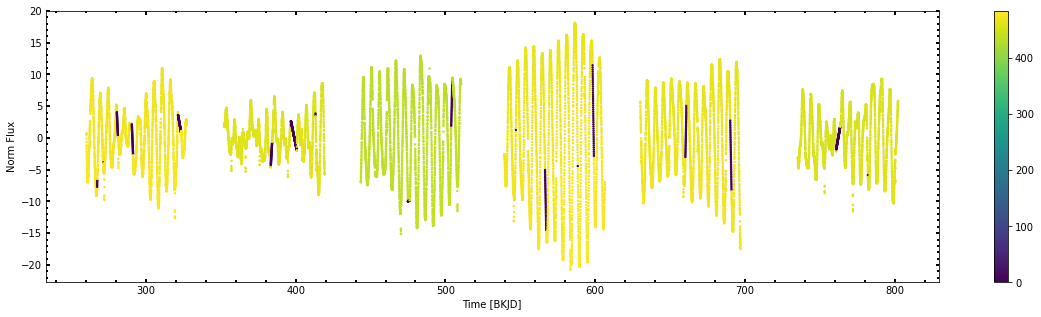

In [7]:
fig, ax = plt.subplots(1, figsize=(20,5))
ax.yaxis.set_ticks_position('both') # ticks appear on both side 
ax.xaxis.set_ticks_position('both') # ticks appear on both side 
ax.tick_params(which='both', direction="in", width=2) # moves the major and minor ticks inside the plot 
ax.minorticks_on() # turn on minor ticks 
ax.tick_params(axis='x', which='minor', bottom=True)  # turn off minor ticks in x-axis
ax.tick_params(axis='x', which='minor', top=True)     # turn off minor ticks in x-axis
plt.ylabel("Norm Flux")
plt.xlabel("Time [BKJD]")
plt.scatter(x_ls, y_ls, c = w_ls, s=2)
plt.colorbar()
plt.show()

### Split the data 

total length:          (6, 3278)
length of training:    (6, 3278)
length of validation:  (6, 0)
length of testing:     (6, 0)


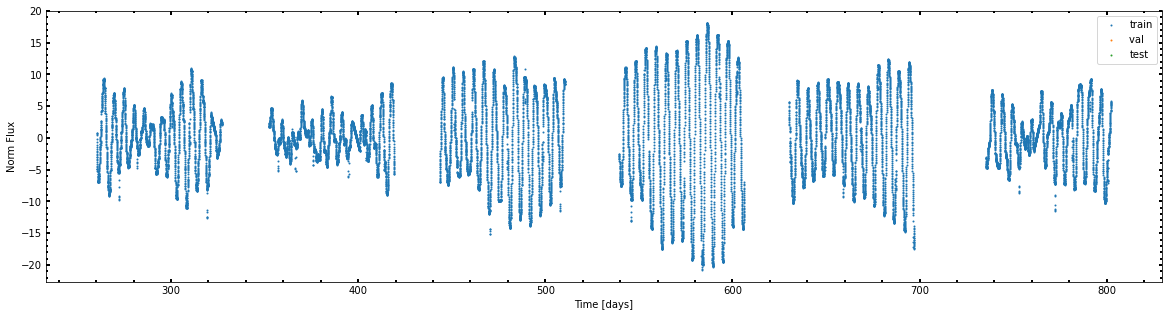

In [8]:
y_train, x_train, y_val, x_val, y_test, x_test, w_train = dp_tools.split_matrices(y_ls, x_ls, w_ls, train_percent=1.0, val_percent=0.0)

#### Define the model 

In [9]:
input_size = 1 # current flux value + p_dt next
output_size = 1 
num_layers = 1 # if > 1, then its stacked
batch_first = True 
bidirectional = False
hidden_size = 50 

# learning rate + weight_decay 
lr = 0.001
wd = 1e-3

lstm = lstm_model.SimpleLSTM(input_size, hidden_size, output_size, num_layers=num_layers, batch_first=batch_first, bidirectional=bidirectional)

optimizer = optim.Adam(lstm.parameters(), lr=lr, weight_decay=wd)

In [10]:
# this indicates the number of parameters we have 
sum(p.numel() for p in lstm.parameters() if p.requires_grad)

10651

In [12]:
# lets convert the list to tensor 
x_train_ls = dp_tools.convert_list2tensor(x_train)
y_train_ls = dp_tools.convert_list2tensor(y_train)
w_train_ls = dp_tools.convert_list2tensor(w_train)

In [13]:
### this is to put into the loader
### if we use the same variable name, it updates it so then it's hard to know when plotting
### these are in tensor format! 
x_train = x_train_ls
w_train = w_train_ls
y_train = y_train_ls 

In [14]:
### hyperparameters that need to be optimized 
# the sequence size in which the mask
seq_size=(5,20)
# the percentage of data to mask
mask_percent = 0.7
# what to set the mask value to 
null_val = -50

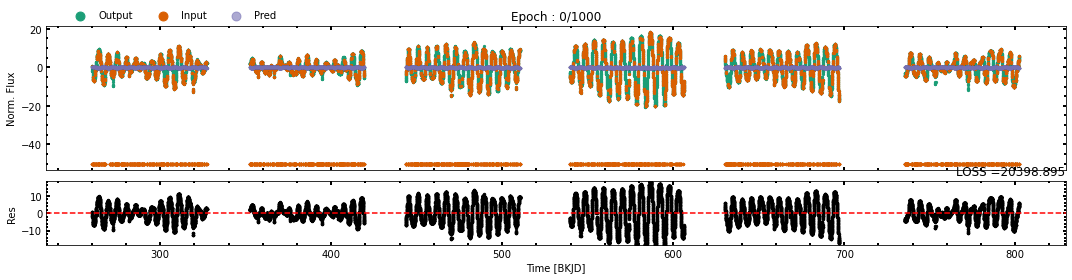

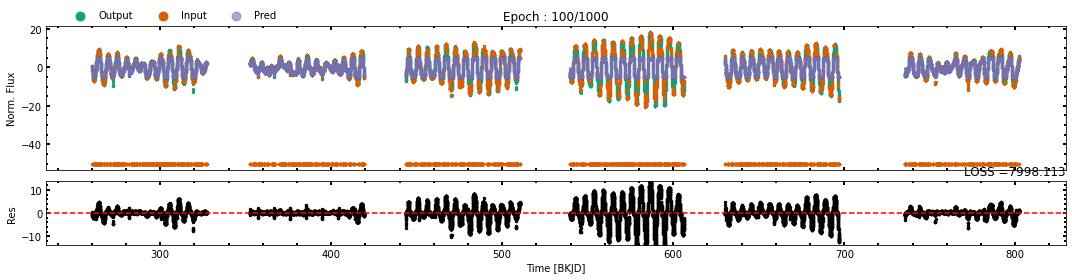

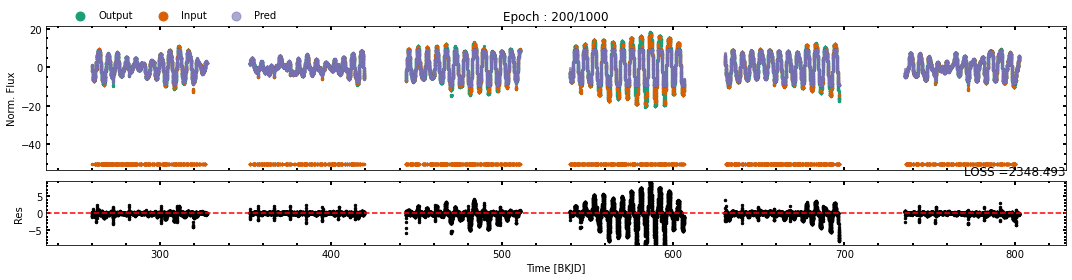

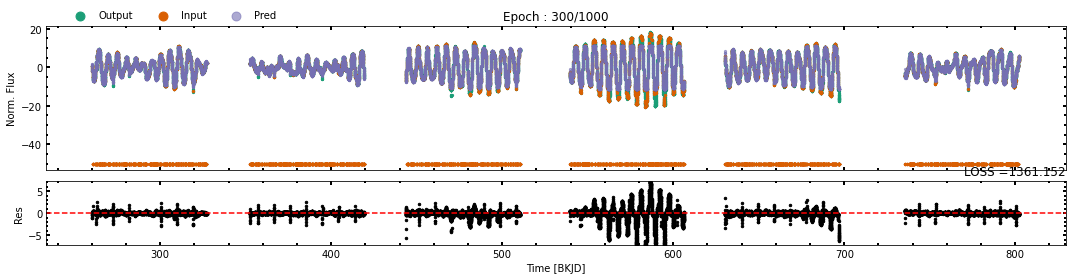

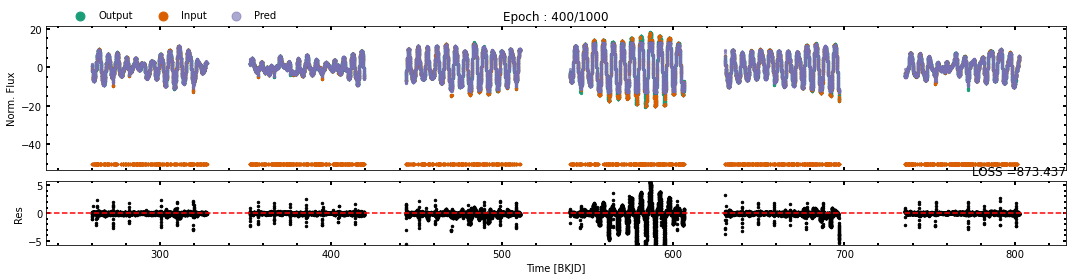

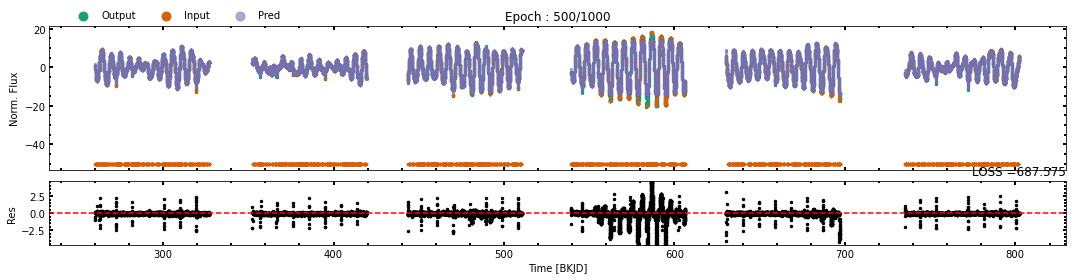

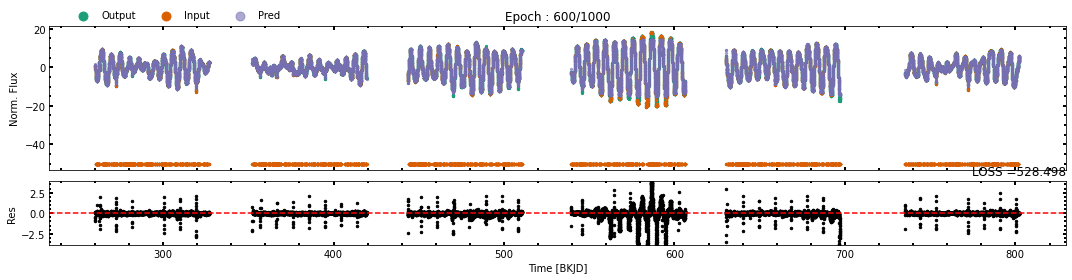

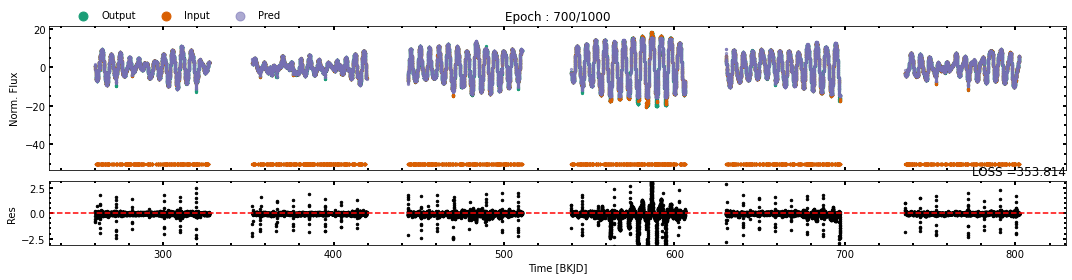

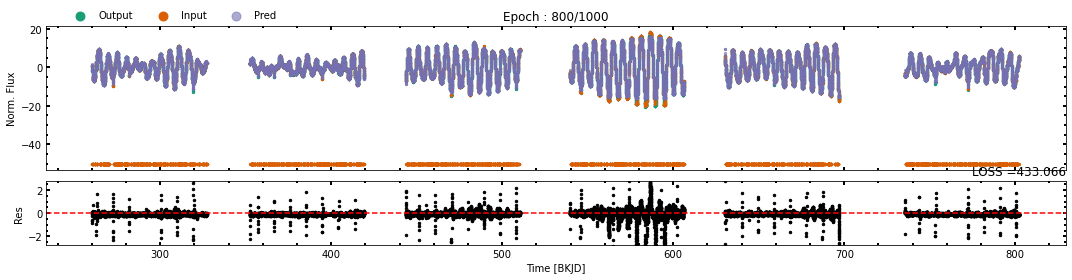

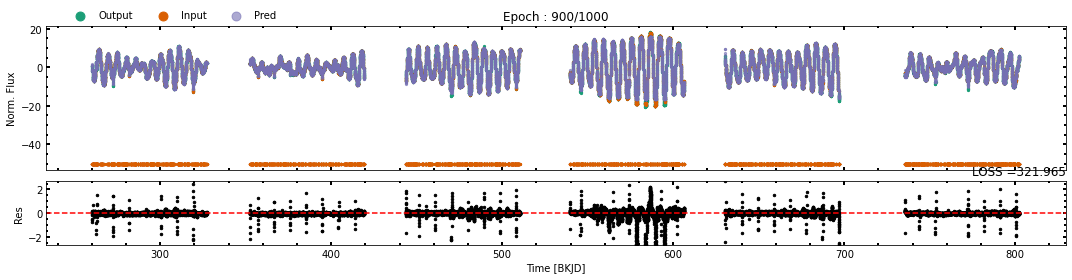

Training complete in 11m 9s


In [15]:
model, hist = training.train_model (lstm, x_train, y_train, w_train, optimizer, n_quarter, null_val, mask_percent, seq_size, 1000, 'mse')

### Get the best weights path  for forecasting into the future 

In [16]:
# saving state_dict() of 'model'
best_wts_pathname = 'uni_weights_only.pth'

# loading the state_dict
model = lstm
model.load_state_dict(torch.load(best_wts_pathname))

<All keys matched successfully>

### Lets check the loss vs. Epoch plot 

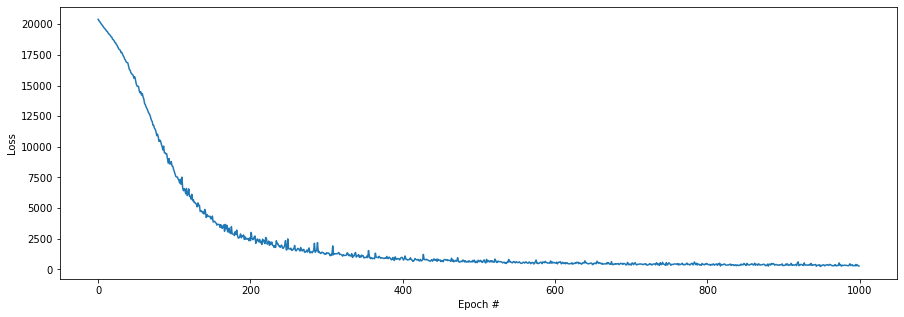

In [17]:
plt.figure(figsize=(15,5))
plt.plot(hist)
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

### Lets get information about transit from published paper 

In [42]:
# source: https://arxiv.org/pdf/1307.8128.pdf
period = 9.4341505 
dur_hr = 2.903 # transit duration 
dur_day = dur_hr/24.0
t0_bjd = 2455010.84307 
t0_bkjd = t0_bjd-2454833.

In [43]:
def expected_transit_time (period, t0_bkjd, x):
    '''
    period [days]
    t0: t0 value [bkjd]
    x: time [bkjd]
    '''
    min_x, max_x = x[0], x[-1]
    min_n, max_n = (min_x - t0_bkjd) / period, (max_x - t0_bkjd) / period
    tr_ls = [] 
    
    for n in range(int(min_n),int(max_n)+1):
        tr_ls.append(t0_bkjd + (period*n))
    return tr_ls

### Testing: Lets apply this model to a different set of campaign 

In [44]:
### change these variables 
mission_name ='Kepler'
cadence_name = 'long'
quarter_num = 11

In [45]:
x, y, w = testing.get_quarter (target_name, mission_name, cadence_name, quarter_num)

In [46]:
# lets remove the linear trend since we removed it during training 
y = dp_tools.remove_linear_trend(x, y)
y = y[0]

In [48]:
# list of expected transit list given the t0 and period 
tr_ls = expected_transit_time(period, t0_bkjd, x) 

In [24]:
# starting i value for the mask 
mask_length = 11
ii = testing.starting_i (mask_length)
# create a mask of windows 
mask_window = testing.rolling_window_masks(y, mask_length=mask_length, ii=ii, plot = False)

In [25]:
rw_flux = testing.unravel_lc (flux_array=y, mask_window=mask_window, model=lstm, null_val=null_val)

Unraveling complete in 9m 1s


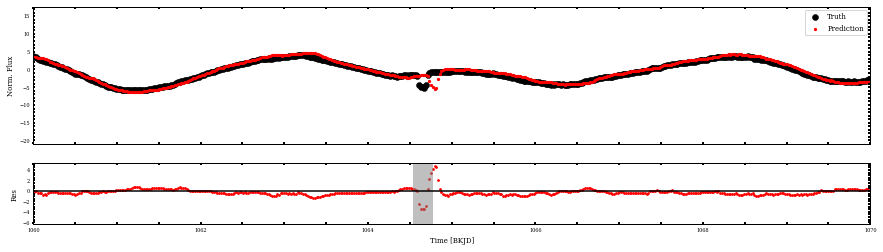

In [125]:
pred_flux = rw_flux
fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(15,4), gridspec_kw={'height_ratios':[9,4]}, sharex=True) 

ax1 = plt.gca()
ax1.yaxis.set_ticks_position('both') # ticks appear on both side 
ax1.xaxis.set_ticks_position('both') # ticks appear on both side 
ax1.tick_params(which='both', direction="in", width=2) # moves the major and minor ticks inside the plot 
ax1.minorticks_on() # turn on minor ticks 
ax1.tick_params(axis='x', which='minor', bottom=True)  # turn off minor ticks in x-axis
ax1.tick_params(axis='x', which='minor', top=True)     # turn off minor ticks in x-axis

ax0.yaxis.set_ticks_position('both') # ticks appear on both side 
ax0.xaxis.set_ticks_position('both') # ticks appear on both side 
ax0.tick_params(which='both', direction="in", width=2) # moves the major and minor ticks inside the plot 
ax0.minorticks_on() # turn on minor ticks 
ax0.tick_params(axis='x', which='minor', bottom=True)  # turn off minor ticks in x-axis
ax0.tick_params(axis='x', which='minor', top=True)     # turn off minor ticks in x-axis

ax1.set_xlabel ("Time [BKJD]")
ax0.set_ylabel ("Norm. Flux")
ax1.set_ylabel ("Res")

ax0.scatter(x, y, label = "Truth", linewidth = 0.5, color = 'k')
ax0.scatter(x, pred_flux, label = "Prediction", s=5, color ='red')
res = y-pred_flux
ax1.axhline(y=0.0, color='k', linestyle='-')
ax1.scatter(x,res, s=3, color = 'red')

for i in range(0,len(tr_ls)):
    ax1.axvspan(tr_ls[i]-dur_day, tr_ls[i]+dur_day, facecolor='0.5', alpha=0.5)
#plt.xlim([1060,1070])
ax0.legend()
plt.show()

In [109]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelweight']='normal'
mpl.rcParams['axes.titleweight']='normal'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams.update({'font.size': 7})
plt.rc('ytick', labelsize=5)    # fontsize of the tick labels
plt.rc('xtick', labelsize=5)    # fontsize of the tick labels

In [ ]:
from astropy.stats import sigma_clip
def get_ylim (data, sigma=3):
    filter_data = sigma_clip (data, sigma, maxiters = 5)
    maxx = np.max(filter_data)
    minn = np.min(filter_data)
    return minn, maxx

In [122]:
def detrend_plot_bls (flux, time, trend, starname, nquarter, method, true_t0, true_period, tr_ls = None, save_file = False):
    mosaic = """
    AA
    DD
    EE
    BC
    """
    fig = plt.figure(constrained_layout=True)
    ax_dict = fig.subplot_mosaic(mosaic, gridspec_kw={
        # set the height ratios between the rows
        "height_ratios": [2, 1, 1.5, 2],
        # set the width ratios between the columns
        "width_ratios": [1, 1], "top": 0.75})
    
    res = flux - trend
    ax_dict['A'].set_title(starname + "| " + method)
    ax_dict['A'].scatter(time, flux, s=10, color = 'k', label = "Data", alpha = 0.2)
    ax_dict['A'].plot(time,trend, lw=1, color = 'red', label = "Trend")
    ax_dict['A'].set_ylabel('Flux [ppt]')
    ax_dict['A'].get_xaxis().set_ticks([])
    ax_dict['A'].set_ylim([get_ylim(flux)[0], get_ylim(flux)[1]])
    ########################################
    
    # this is to add in transits 
    if tr_ls != None:
        for i in range(0,len(tr_ls)):
            ax_dict['D'].axvspan(tr_ls[i]-0.25, tr_ls[i]+0.25, alpha=0.6, facecolor='darkgray')
    ax_dict['D'].scatter(time, res, s=10, color = 'k', alpha = 0.2)
    ax_dict['D'].set_xlabel('BKJD [days]')
    ax_dict['D'].set_ylabel('Residuals')
    #ax_dict['D'].set_ylim([get_ylim(res)[0], get_ylim(res)[1]])
    #ax_dict['D'].set_ylim([-200, 200])
    ########################################
    phase = phase_fold(time, true_t0, true_period)
    ax_dict['E'].scatter(phase, flux-trend, s=10, color = 'k', alpha = 0.2)
    ax_dict['E'].set_xlim([-0.5,0.5])
    #ax_dict['E'].set_ylim([-2000,2000])
    ax_dict['E'].set_ylabel('Flux')
    ax_dict['E'].set_xlabel('Phase')
    ########################################
    pg = xo.estimators.bls_estimator(time, res, min_period=2, max_period=20)
    peak = pg["peak_info"]
    period_guess = peak["period"]
    t0_guess = peak["transit_time"]
    depth_guess = peak["depth"]
    
    max_power = np.max(pg["bls"].power)
    ax_dict['B'].plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
    ax_dict['B'].axvline(period_guess, alpha=0.3, linewidth=5)
    ax_dict['B'].set_title("Power="+ str(np.round(max_power,2)) + " | P=" + str(np.round(peak['period'],2)) + ' d', fontsize=7)
    ax_dict['B'].semilogx()
    ax_dict['B'].set_xlabel('Period [days]')
    ax_dict['B'].set_ylabel('BLS Power')

    ########################################

    x_fold = (time - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
    ax_dict['C'].set_title("d= "+ str(np.round(peak['depth'],4)) + '%', fontsize=7)
    ax_dict['C'].scatter(x_fold, res, c=time, s=10)
    ax_dict['C'].set_xlabel('Phase')
    ax_dict['C'].set_ylabel('Flux [ppt]')
    ax_dict['C'].set_xlim([-0.25,0.5])
    #ax_dict['C'].set_ylim([-2000,2000])
    plt.tight_layout()
    if save_file == True:
        filename = starname + '_n' + str(nquarter) + '_'+method 
        fig.savefig(filename + ".png", dpi = 500, transparent=True)
    plt.show()
    return 

<ipython-input-122-51122f968971>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


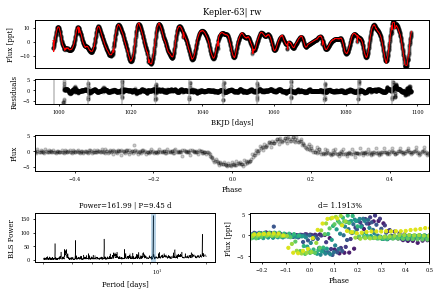

In [124]:
detrend_plot_bls (flux, time, trend, starname=target_name, nquarter=nquarter, method='rw', true_t0=t0_bkjd, true_period=period, tr_ls = tr_ls, save_file = True)

### Calculate the loss 

In [126]:
rw_flux_tensor = dp_tools.convert_list2tensor(rw_flux)
y_tensor =  dp_tools.convert_list2tensor(y )
w_tensor =  dp_tools.convert_list2tensor(w )

In [127]:
loss = training.weighted_mse_loss(rw_flux_tensor,y_tensor, w_tensor)
print (loss)

tensor(260.5699)


### Lets now mask the transt and apply the rolling window 

In [129]:
transit_i_ls = [] 
for i in range(0,len(x)):
    for j in range(0,len(tr_ls)):
        if x[i] > tr_ls[j] - (dur_day) and x[i] < tr_ls[j]+ (dur_day):
            transit_i_ls.append(i) # ("TRUE")

In [132]:
# for when the transit happens -- lets set it to the null_val 
for i in range(0,len(transit_i_ls)):
    y[transit_i_ls[i]]=null_val

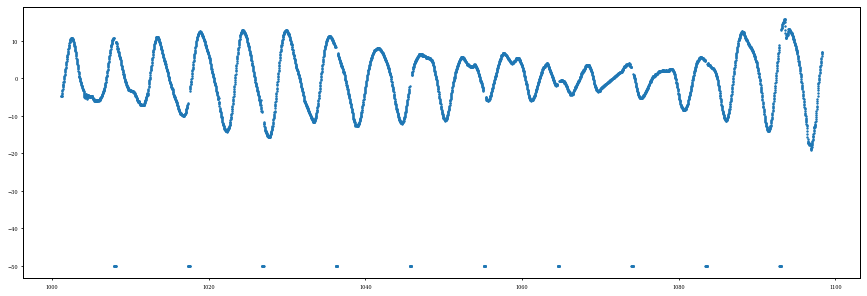

In [135]:
fig, ax = plt.subplots(1,figsize=(15,5))
plt.scatter(x,y, s= 2)
plt.show()

In [136]:
rw_flux = testing.unravel_lc (flux_array=y, mask_window=mask_window, model=lstm, null_val=null_val)

Unraveling complete in 9m 20s


<ipython-input-122-51122f968971>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


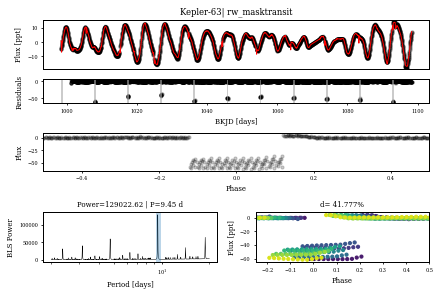

In [137]:
detrend_plot_bls (flux, time, trend, starname=target_name, nquarter=nquarter, method='rw_masktransit', true_t0=true_t0, true_period=true_period, tr_ls = tr_ls, save_file = True)